In [81]:
import torch
import matplotlib.pyplot as plt

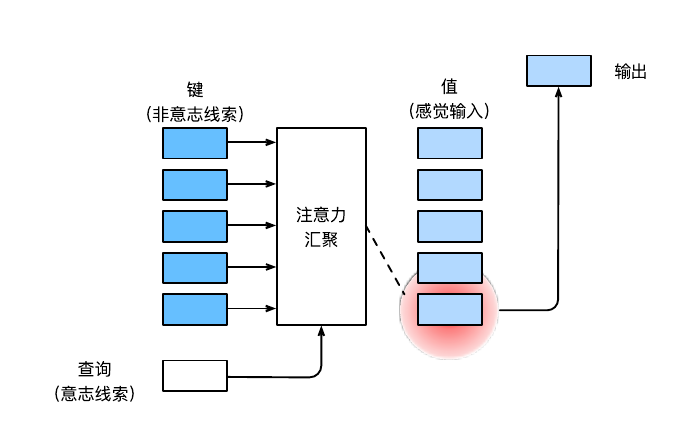

# 矩阵热图

In [82]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5,2.5),
                  cmap='Reds'):
  """
  显示矩阵热图
  Parameters:
    figsize: 每个子图的大小
    cmap: 热图的颜色映射
  """
  num_rows, num_cols = matrices.shape[0], matrices.shape[1]
  # 创建包含多个子图的图像, fig是整个图像， axes是子图的网格, sharex和sharey是共享坐标轴,
  # squeeze确保axes始终为二维数组
  fig, axes =plt.subplots(num_rows, num_cols, figsize=figsize,
                          sharex=True,sharey=True, squeeze=False)
  for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
    for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
      pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
      if i == num_rows - 1:
        ax.set_xlabel(xlabel)
      if j == 0:
        ax.set_ylabel(ylabel)
      if titles:
        ax.set_title(titles[j])
  fig.colorbar(pcm, ax=axes)

tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]])


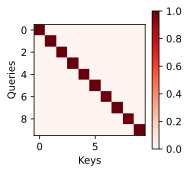

In [101]:
attention_weights = torch.eye(10).reshape((1,1,10,10))
print(attention_weights)
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# 注意力汇聚-Nadaraya-Watson核回归

In [84]:
from torch import nn
from dltool import plot,dataprocess,train

In [85]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)
x_train

tensor([0.1237, 0.2248, 0.2265, 0.3305, 0.3371, 0.3402, 0.3504, 0.4350, 0.5536,
        0.8199, 0.9602, 0.9882, 1.0942, 1.2382, 1.2789, 1.3550, 1.3744, 1.5141,
        1.7545, 1.8278, 1.8424, 1.8961, 1.9985, 2.0091, 2.0293, 2.1324, 2.2391,
        2.3124, 2.3416, 2.3865, 2.6378, 2.7486, 2.7815, 2.8843, 3.1572, 3.3734,
        3.4769, 3.5114, 3.5518, 3.5835, 3.5859, 3.6728, 3.6827, 3.8654, 4.0230,
        4.0624, 4.1481, 4.3530, 4.4373, 4.8310])

In [86]:
def f(x):
  return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0,5,0.1)
y_truth = f(x_test)
n_test = len(x_test)

In [87]:
def plot_kernel_reg(y_hat):
  plt.plot(x_test, y_truth, label='Truth')
  plt.plot(x_test, y_hat, label='Pred')
  plt.plot(x_train,y_train,'o',alpha=0.5)
  plt.xlim(0,5)
  plt.ylim(-1,5)
  plt.legend()
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()
  

## 平均汇聚

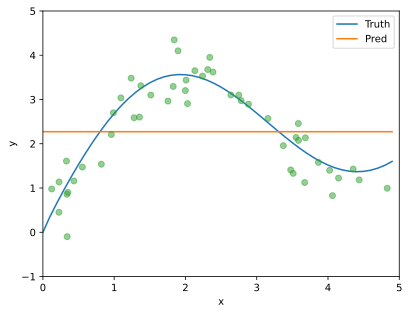

In [88]:
# 估计器
y_hat = torch.repeat_interleave(y_train.mean(),n_test)
plot_kernel_reg(y_hat)

## 非参数注意力汇聚
- 平均汇聚忽略了位置
- NW核回归考虑了输入位置，根据输入位置对输出$y_i$进行加权
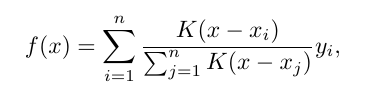
- 改写成更通用的注意力汇聚公式：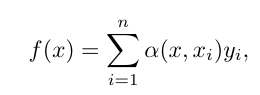
  - x是查询，$(x_i,y_i)$是键值对

In [102]:
# X_repeat(n_test, n_train)
# 每一行都包含相同的测试输入
X_repeat = x_test.repeat_interleave(n_train).reshape((-1,n_train))
X_repeat

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]])

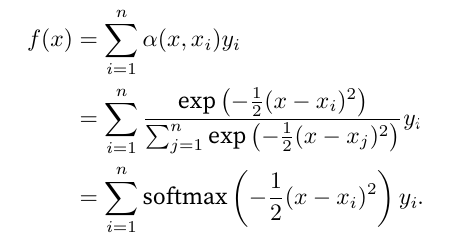

测试数据的输入X_repeat相当于查询，训练数据的输入x_train相当于键。

In [105]:
# x_train包含键，attention_weights的形状：(n_test, n_train)
# 每一行为在给定的每个查询值(y_train)之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
attention_weights.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 50, 50])

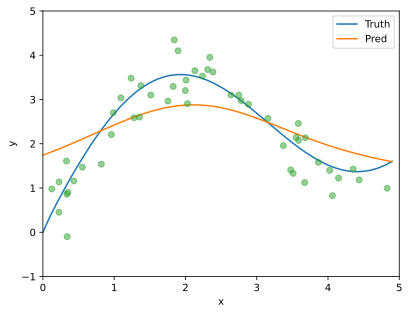

In [91]:
# y_hat中的元素是值的加权平均值，权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

由于两个输入（查询和键）都排过序，所以值都会比较接近，而越接近，注意力权重就越高

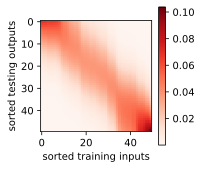

In [92]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='sorted training inputs',
              ylabel='sorted testing outputs')

## 带参注意力汇聚

In [93]:
# 批量矩阵乘法
X = torch.ones((2,1,4))
Y = torch.ones((2,4,6))
## X1Y1,X2Y2,X3Y3...
torch.bmm(X,Y).shape

torch.Size([2, 1, 6])

In [94]:
weights = torch.ones((2,10)) * 0.1
# print(weights.unsqueeze(-1).shape)
values = torch.arange(20.0).reshape((2,10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [95]:
class NWKernelRegression(nn.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
  
  def forward(self, queries, keys, values):
    # quires和attention_weights的形状为(查询个数，“键-值”对个数)
    queries = queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
    self.attention_weights = nn.functional.softmax(
      -(((queries - keys) * self.w )** 2) / 2, dim=1)   
    # values的形状为(查询个数，“键-值”对个数)
    return torch.bmm(self.attention_weights.unsqueeze(1),
                     values.unsqueeze(-1)).reshape(-1)

# 训练

In [96]:
# X_tile的形状:(n_train, n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train,1))
# Y_tile的形状:(n_train, n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train,1))
# keys的形状:('n_train','n_train'-1)
keys = X_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
# values的形状:('n_train','n_train'-1)
values = Y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))

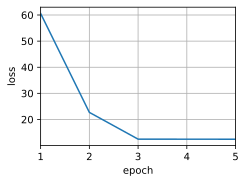

In [97]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = plot.Animator(xlabel='epoch', ylabel='loss', xlim=[1,5])

for epoch in range(5):
  trainer.zero_grad()
  l = loss(net(x_train, keys, values), y_train)
  l.sum().backward()
  trainer.step()
  print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
  animator.add(epoch+1,float(l.sum()))

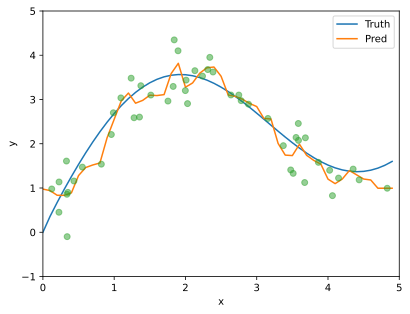

In [98]:
# keys的形状：(n_test, n_train),每一行包含着相同的训练输入
keys = x_train.repeat((n_test,1))
# value的形状:(n_test, n_train)
values = y_train.repeat((n_test,1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

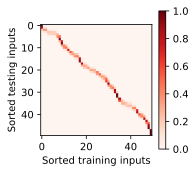

In [99]:
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')